In [2]:
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import time
import numpy as np
from tensorflow.keras.models import load_model
import scipy

In [30]:
model=load_model('cornerdetector.h5',compile=False)

In [11]:
new_model=tf.keras.Sequential()
for x in model.layers:
    if(x.name=='convDa' or x.name=='convDb' or x.name=='NormLayer' or x.name=='DivideLayer'):
        pass
    else:
        new_model.add(x)

In [12]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
conv1b (Conv2D)              (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2a (Conv2D)              (None, None, None, 64)    36928     
_________________________________________________________________
conv2b (Conv2D)              (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv3a (Conv2D)              (None, None, None, 128)  

In [28]:
new_model.save('cornerdetector.h5')

In [31]:
# read image - grayscale - np.float32/255.0 to normalize 
img=cv2.imread('doors.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
#img=cv2.resize(img,(240,320),interpolation=cv2.INTER_AREA)
img=img.astype(np.float32)/255.0

(200, 477)


In [32]:
#assert that image is grayscale and float32 
#expand image dimensions
assert img.ndim == 2, 'Image must be grayscale.'
assert img.dtype == np.float32, 'Image must be float32.'
t_to_k = lambda x: x.swapaxes(1, 3).swapaxes(2, 3)
H, W = img.shape[0], img.shape[1]
inp = np.expand_dims(np.expand_dims(img,0), -1)
print(inp.shape)

(1, 200, 477, 1)


In [33]:
#pass image to the model
semi = model.predict(inp)
#semi = new_model.predict(inp)

In [34]:
# change shape of ouput points 
print(semi.shape)
semi = t_to_k(semi).squeeze()
print(semi.shape)

(1, 25, 59, 65)
(65, 25, 59)


In [35]:
#applying softmax to output 

dense = np.exp(semi) # Softmax.
dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
nodust = dense[:-1, :, :]

In [36]:
#adjusting shape 
print(nodust.shape)
nodust = nodust.transpose(1, 2, 0)
print(nodust.shape)

(64, 25, 59)
(25, 59, 64)


In [37]:
cell = 8
Hc = int(H / cell)
Wc = int(W / cell)
print(Hc,Wc)

25 59


In [38]:
print(nodust.shape)
heatmap = np.reshape(nodust, [Hc, Wc, cell, cell])
print(heatmap.shape)
heatmap = np.transpose(heatmap, [0, 2, 1, 3])
print(heatmap.shape)
heatmap = np.reshape(heatmap, [Hc*cell, Wc*cell])
print(heatmap.shape)

(25, 59, 64)
(25, 59, 8, 8)
(25, 8, 59, 8)
(200, 472)


In [39]:
conf_thresh=0.015

In [40]:
xs, ys = np.where(heatmap >= conf_thresh) # Confidence threshold

In [41]:
print(xs.shape,ys.shape)

(1108,) (1108,)


In [42]:
pts = np.zeros((3, len(xs))) # Populate point data sized 3xN
print(pts.shape)

(3, 1108)


In [43]:
pts[0, :] = ys
pts[1, :] = xs
pts[2, :] = heatmap[xs, ys]

In [44]:
img_out=img.copy()
for i in range(len(pts[0])):
    pt1 = (int(pts[0][i]), int(pts[1][i]))
    cv2.circle(img_out, pt1, 1, (0, 255, 0), -1, lineType=16)
    
    

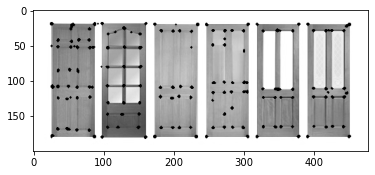

In [45]:
plt.imshow(img_out,cmap="gray")
plt.show()

In [62]:
def detect_corners(imgpath,modelpath,conf_thresh):
    model=load_model(modelpath,compile=False)
    img=cv2.imread(imgpath)
    plt.imshow(img)
    plt.show()
    img_out=img.copy()
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img.astype(np.float32)/255.0
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    t_to_k = lambda x: x.swapaxes(1, 3).swapaxes(2, 3)
    H, W = img.shape[0], img.shape[1]
    inp = np.expand_dims(np.expand_dims(img,0), -1)
    semi, _ = model.predict(inp)
    semi = t_to_k(semi).squeeze()
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) 
    nodust = dense[:-1, :, :]
    nodust = nodust.transpose(1, 2, 0)
    cell = 8
    Hc = int(H / cell)
    Wc = int(W / cell)
    heatmap = np.reshape(nodust, [Hc, Wc, cell, cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*cell, Wc*cell])
    xs, ys = np.where(heatmap >= conf_thresh)
    pts = np.zeros((3, len(xs)))
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    
    for i in range(len(pts[0])):
        pt1 = (int(pts[0][i]), int(pts[1][i]))
        cv2.circle(img_out, pt1, 1, (0, 255, 0), -1, lineType=16)
    return img_out
    

    
    

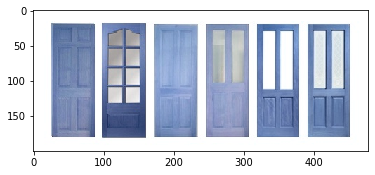

In [63]:
out=detect_corners('doors.jpg','superpointnet_keras.h5',0.015)

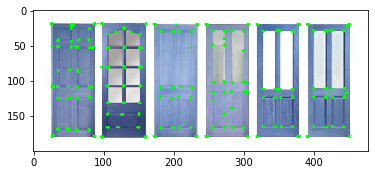

In [64]:
plt.imshow(out)
plt.show()